In [1]:
import nltk.data
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")


from IPython.display import display
import timeit
from collections import defaultdict
import math
import numpy as np
import pandas as pd
import random
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as md
%matplotlib inline
import operator 

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from bs4 import BeautifulSoup
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import sentiment
from autocorrect import spell # For spelling correction
from urllib import request

In [2]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [3]:
df = pd.read_csv('reference/Amazon_Unlocked_Mobile.csv', delimiter = ",")
n = len(df)
df.columns = ['Product', 'Brand', 'Price', 'Rating', 'Review', 'Votes']
df['id_col'] = range(0, n)
df['Label'] = 0
df.loc[df['Rating'] >= 3, 'Label'] = 1


df.head()

,Product,Brand,Price,Rating,Review,Votes,id_col,Label
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,0,1
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,1,1
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,2,1
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,3,1
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,4,1


In [4]:
df.shape

(413840, 8)

In [5]:
df.dropna(subset=['Review'], how='all', inplace=True)
df.shape

(413778, 8)

In [6]:
one = np.sum(df['Label'] == 1)
two = np.sum(df['Label'] == 0)
three = np.sum(df['Label'] == -1)
display(one)
display(two)
display(three)
display(one+two+three)

316717

97061

0

413778

In [7]:
def clean_review(review, remove_stopwords = False):
    """Helper function to clean the reviews i.e. to convert a document to a sequence of words.
     Please note that we're not removing stopwords since word2vec relies on the broader context
     of the sentence in order to produce high-quality word vectors.

     Arg: review: review string (str)
          remove_stopwards: If true remove stopwords else not. (boolean)
     Returns: cleaned_review : Cleaned review (list)

     You should carry out the following steps.
     1. Remove HTML Tags.
     2. Remove non-letter characters.
     3. Convert to lower case.
    """
    
    review_html = BeautifulSoup(review).get_text() 
    letter = re.compile('[^a-zA-Z]')
    review_letter = re.sub(letter,' ',review_html)
    review_lower = review_letter.lower().split()
    cleaned_review = []
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        for w in review_lower:

            if w not in stop_words:
                cleaned_review.append(get_synonym(w))
    else:
         for w in review_lower:
            cleaned_review.append(w)
    

    #####################
    
    return cleaned_review

def get_synonym(word):
    synonyms = [["camera","video", "display"], 
                ["phone", "cellphone", "smartphone", "phones"],
               ["setting", "settings"],
               ["feature", "features"],
               ["pictures", "photos"],
               ["speakers", "speaker"]]
    synonyms_parent = ["camera", "phone", "settings", "features", "photos", "speakers"]
    
    for i in range(len(synonyms)):
        if word in synonyms[i]:
            return synonyms_parent[i]
    
    return word

In [8]:
clean_review(df['Review'][0], remove_stopwords=True)

['feel',
 'lucky',
 'found',
 'used',
 'phone',
 'us',
 'used',
 'hard',
 'phone',
 'line',
 'someone',
 'upgraded',
 'sold',
 'one',
 'son',
 'liked',
 'old',
 'one',
 'finally',
 'fell',
 'apart',
 'years',
 'want',
 'upgrade',
 'thank',
 'seller',
 'really',
 'appreciate',
 'honesty',
 'said',
 'used',
 'phone',
 'recommend',
 'seller',
 'highly',
 'would']

In [9]:
def review_to_sentences(review, tokenizer):
    """Helper function to split a review into parsed sentences. Returns a 
     list of sentences, where each sentence is a list of words.

     Arg: review: review string (str)
          tokenizer: punkt tokenizer
     Returns:
          review_sentences: List of list of tokens.
                            e.g. [["word2vec", "was", "introduced", "by", "google" ],["it","leverages","distributed","token","representations"]]

     You should carry out the following steps.
     1. Use the tokenizer to split the paragraph into sentences.
     2. Clean the sentence to return a list of words for each sentence using the helper funtion above.
     3. Return a list of tokenized sentences.
    """
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append(clean_review(raw_sentence))
    
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences
    


In [10]:
# Use the above helper functions to convert the reviews in train["review"] and in unlabeled_train["review"] to a list of list format as mentioned above.
# For example if your train data contains 2 reviews with 3 sentences in each and the unlabeled_train has 4 reviews with 1 sentence in each
# The resultant list should have 10 lists of tokenized sentences.
sentences = []  # Initialize an empty list of sentences

print("Parsing sentences from training set")
### Add your code here.
tic=timeit.default_timer()
i = 1
for review in df["Review"]:
    sentences += review_to_sentences(review, tokenizer)
    if i%10000 == 0:
        print('progress: ', (i/len(df["Review"]))*100, "%")
    i = i + 1

    toc=timeit.default_timer()

print("minutes: ", (toc - tic)/60)


Parsing sentences from training set
progress:  2.416754878219722 %
progress:  4.833509756439444 %
progress:  7.250264634659165 %
progress:  9.667019512878888 %
progress:  12.08377439109861 %
progress:  14.50052926931833 %
progress:  16.91728414753805 %
progress:  19.334039025757775 %
progress:  21.750793903977495 %
progress:  24.16754878219722 %
progress:  26.584303660416936 %
progress:  29.00105853863666 %
progress:  31.417813416856383 %
progress:  33.8345682950761 %
progress:  36.25132317329582 %
progress:  38.66807805151555 %
progress:  41.08483292973527 %
progress:  43.50158780795499 %
progress:  45.91834268617471 %
progress:  48.33509756439444 %
progress:  50.75185244261415 %
progress:  53.16860732083387 %
progress:  55.5853621990536 %
progress:  58.00211707727332 %
progress:  60.418871955493046 %
progress:  62.835626833712766 %
progress:  65.25238171193249 %
progress:  67.6691365901522 %
progress:  70.08589146837193 %
progress:  72.50264634659165 %
progress:  74.91940122481138 %


In [11]:
print(sentences[0])

['i', 'feel', 'so', 'lucky', 'to', 'have', 'found', 'this', 'used', 'phone', 'to', 'us', 'not', 'used', 'hard', 'at', 'all', 'phone', 'on', 'line', 'from', 'someone', 'who', 'upgraded', 'and', 'sold', 'this', 'one']


## 1. Word2Vec

In [12]:
from gensim.models import word2vec, KeyedVectors

In [13]:
print(len(sentences))

1224063


In [14]:
def generate_z1(sentences,num_features,min_word_count,context,num_workers = 4,downsampling = 1e-3, model_name = "model1_100features_40minwords_5context"):
    """Set values for the parameters of the your word2vec model and train it on the extracted sentences from both the train and unlabeled_train data and
      generate the collection of these representations Z1.
      You should carry out the following.
      1) Set the parameters as mentioned below. 
        A)Constrained Paramters : "context length", "embedding dimension", "min_words" (Please check the question for the values.)
        B)Optional Parameters: "number of workers", "downsample setting"
      2) Train your word2vec model and save it.
      3) Store the collection of word embeddings and the word_list(z1 and word_list_z1) .

      Arg: sentences: List of tokenized sentences (List)
            num_features: Word vector dimensionality (int)
            min_word_count: Minimum word count (int)
            context: Context window size (int)
            num_workers: Number of threads to run in parallel (int)
            downsampling: Downsample setting for frequent words (float)
            model_name = Name to save your model (str)
      Returns:
            trained_word2vec_model: word2vec model trained on the tokenized sentences.
            z1: word embeddings (ndarray)
            word_list_z1: List of tokens in the model (List)

      

    """
    print("Training model...")
    ### Add your code here.
    model = word2vec.Word2Vec(sentences, \
                              workers=num_workers, \
                              size=num_features, \
                              min_count = min_word_count, \
                              window = context,  \
                              sample = downsampling)
    
    model.init_sims(replace=True)
    model.save(model_name)
    
    z1 = model.wv.syn0
    word_list_z1 = model.wv.index2word
    
    return model, z1, word_list_z1


# Set values for the parameters of the your word2vec model and train it on the extracted sentences from both the train and unlabeled_train data and
# generate the collection of these representations Z1.
# Add the function parameter values below.
### Add your code here.

######################
num_features = 100    # Word vector dimensionality
min_word_count = 40   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 5          # Context window size
downsampling = 1e-3 


model1, z1, word_list_z1 = generate_z1(sentences,num_features=num_features, min_word_count=min_word_count, context=context)




Training model...


In [15]:
word_list_z1

['the',
 'i',
 'it',
 'and',
 'phone',
 'a',
 'to',
 'is',
 'this',
 'for',
 'with',
 'of',
 'my',
 'not',
 'was',
 'in',
 'that',
 't',
 'but',
 'on',
 'you',
 'have',
 's',
 'great',
 'good',
 'as',
 'very',
 'so',
 'had',
 'one',
 'be',
 'no',
 'all',
 'can',
 'at',
 'like',
 'screen',
 'me',
 'use',
 'just',
 'if',
 'from',
 'battery',
 'or',
 'has',
 'are',
 'an',
 'works',
 'when',
 'would',
 'get',
 'only',
 'love',
 'will',
 'new',
 'up',
 'work',
 'they',
 'out',
 'than',
 'time',
 'camera',
 'really',
 'price',
 'about',
 'product',
 'do',
 'am',
 'its',
 'well',
 'sim',
 'after',
 'bought',
 'what',
 'phones',
 'because',
 'm',
 'there',
 'more',
 'card',
 'don',
 'buy',
 'even',
 'got',
 'other',
 'now',
 'iphone',
 'back',
 'which',
 'excellent',
 'nice',
 'does',
 'also',
 'your',
 'any',
 'some',
 'apps',
 'did',
 'fast',
 'quality',
 'g',
 'used',
 'much',
 'still',
 'better',
 'been',
 'came',
 'by',
 'first',
 'android',
 'unlocked',
 'could',
 'problem',
 've',
 'eve

In [16]:
# z2.shape

In [17]:
# len(word_list_z2)

In [18]:
def fit_kmeans(z,word_list_z,num_clusters = 10):
    """ Fit kmeans on the embedding representations and return a mapping of word to cluster indices. Please use the default values for
        the rest of the kmeans parameters.

        Arg: z: word embeddings (ndarray)
              word_list_z: List of tokens in the model (List) 
              num_clusters: Number of clusters (int)
        Returns:
            pre_trained_word2vec_model: word2vec model trained on the tokenized sentences.
            z2: word embeddings (ndarray)
            word_centroid_map_z: A mapping of word to cluster index it belongs to. (Dict)      

    """
    km = KMeans(n_clusters=num_clusters)
    idx = km.fit_predict(z)
    word_centroid_map_z = dict(zip(word_list_z, idx))
    
    return word_centroid_map_z


word_centroid_map_z1 = fit_kmeans(z1, word_list_z1, 10)

In [19]:
def print_clusters(word_centroid_map_z, model_name):
    """ Print max(20, cluster_size) words for each of the clusters.

        Args: word_centroid_map_z: A mapping of word to cluster index it belongs to. (Dict)  
              model_name: Model Name (str)


    """
    print("The clusters for {0} are....".format(model_name))
    for i in range(len(set(word_centroid_map_z1.values()))):
        print('cluster #', i, ':')
        words = []
        for k, v in word_centroid_map_z.items():
            if v == i:
                words.append(k)
            if len(words)==20:
                break
        print(words)
        print()

        
        
        
    
print_clusters(word_centroid_map_z1, "model1")
print()


The clusters for model1 are....
cluster # 0 :
['had', 'can', 'would', 'love', 'will', 'about', 'bought', 'don', 'does', 'did', 'used', 'by', 'could', 'happy', 'received', 'however', 'expected', 'able', 'many', 'purchased']

cluster # 1 :
['with', 's', 'as', 'from', 'an', 'than', 'iphone', 'which', 'g', 'android', 've', 'samsung', 'gb', 'blu', 'same', 'old', 'galaxy', 'brand', 'apple', 'version']

cluster # 2 :
['of', 'are', 'phones', 'there', 'apps', 'problem', 'device', 'how', 'thing', 'problems', 'way', 'features', 'were', 'issues', 'issue', 'memory', 'these', 'pictures', 'people', 'software']

cluster # 3 :
['on', 'no', 'battery', 'only', 'up', 'time', 'after', 'even', 'got', 'now', 'back', 'still', 'came', 'first', 'using', 'off', 'working', 'then', 'day', 'doesn']

cluster # 4 :
['excelente', 'y', 'el', 'de', 'que', 'en', 'la', 'muy', 'con', 'lo', 'es', 'producto', 'un', 'se', 'bueno', 'por', 'bien', 'para', 'telefono', 'buen']

cluster # 5 :
['i', 'it', 'phone', 'a', 'to', 'this'

In [20]:
# Create tokenized reviews for both train and test. Please note that for this we'll not be splitting the sentences and we'll be removing stopwords.
# This is exactly what you did in the preprocessing step for HW1
clean_reviews = []

for review in df['Review']:
    clean_reviews.append(clean_review(review, remove_stopwords=True))


In [21]:
clean_reviews[0]

['feel',
 'lucky',
 'found',
 'used',
 'phone',
 'us',
 'used',
 'hard',
 'phone',
 'line',
 'someone',
 'upgraded',
 'sold',
 'one',
 'son',
 'liked',
 'old',
 'one',
 'finally',
 'fell',
 'apart',
 'years',
 'want',
 'upgrade',
 'thank',
 'seller',
 'really',
 'appreciate',
 'honesty',
 'said',
 'used',
 'phone',
 'recommend',
 'seller',
 'highly',
 'would']

In [22]:
def create_bag_of_centroids(tokenized_review, word_centroid_map, num_clusters = 10):
    """ Create a bag of kmeans centroids for each review i.e. for a review we return an array of length num_clusters with each 
        element of the array indicating how many words(tokens) of the review belong to that cluster.

        Args: tokenized_review: list of tokens corresponding to a review (List)
              word_centroid_map: word to cluster_index map for the model (Dict)
              num_clusters: Number of clusters (int)
        
        Returns: bag_of_centroids: An array containing the count of tokens in each cluster (ndarray)
    """
    bag_of_centroids = np.zeros(num_clusters, dtype='int')
    for word in tokenized_review:
        if word in word_centroid_map:
            bag_of_centroids[word_centroid_map[word]] += 1
    
    return bag_of_centroids

In [23]:
# create_bag_of_centroids(clean_train_reviews[0], word_centroid_map_z2)

In [24]:
# create_bag_of_centroids(sentences[0], word_centroid_map_z1, num_clusters = 10)

In [25]:
# np.zeros((3,4), dtype='int')[1]

In [26]:
# clean_train_reviews[0]

In [27]:
def create_design_matrices(data, cleaned_reviews, word_centroid_map_z1, num_clusters = 10):
    """ Creates the design matrices X1(for trained model) and X2(for pretrained google word2vec model) for the given data

        Args: data: Train/Test data (pandas.core.frame.DataFrame)
              cleaned_reviews: List of tokenized reviews(sentences are not split and stopwords removed) (List)
              word_centroid_map_z1: word to cluster map for model1 (Dict)
              word_centroid_map_z2: word to cluster map for model2 (Dict)
              num_clusters: Number of KMeans clusters (int)

        Returns:
              x1_data: Design matrices X1-- Shape should be num_reviews*num_clusters (np.ndarray) 
              x2_data: Design matrices X2-- Shape should be num_reviews*num_clusters (np.ndarray)


    """
    x1_data = np.zeros((len(cleaned_reviews), num_clusters), dtype='int')

    
    for i in range(len(cleaned_reviews)):
        x1_data[i] = create_bag_of_centroids(cleaned_reviews[i], word_centroid_map_z1, num_clusters)

    
    return x1_data






x1_data = create_design_matrices(df,clean_reviews,word_centroid_map_z1,10)



In [28]:
y = df['Label'].as_matrix()
display(y.shape)
x1_data.shape

(413778,)

(413778, 10)

## 2. Classification

In [29]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [30]:
def split(X, label):
    """Helper function to create a train-test split of the data.(test_size = 0.2, random_state = 0)

     Arg: X: Design Matrix(ndarray)
          label: sentiment values
     Returns:
          x_train: train input features
          x_test: test input features
          y_train: train labels
          y_test: test labels
    """
    
    x_train, x_test, y_train, y_test = train_test_split(X, label, test_size=0.2, random_state=0)
    

    return x_train, x_test, y_train, y_test

In [31]:
x1_train_split, x1_test_split, y1_train_split, y1_test_split = split(x1_data, y)

In [32]:
# # Random Forest
# def cross_val(x_train_split,y_train_split,n_estimators):
#     """function to calculate the cross validation scores for the 2 values of x_train, and y_train on the Random 
#         Forest Classifier.

#      Arg: x_train_split: train input features
#           y_train_split: train labels
#           n_estimators: List of estimators to perform Random Forest with.
#      Returns:
#           cross_val_scores: List of the CV scores the estimators (list)
#     """
    
#     cross_val_scores = []
#     for n in n_estimators:
#         print(n, '...')
#         rf = RandomForestClassifier(n_estimators=n)
#         scores = cross_val_score(rf, x_train_split, y_train_split)
#         cross_val_scores.append(scores.mean())
        
#     return cross_val_scores



# n_estimators = [50]
# result1 = cross_val(x1_train_split,y1_train_split,n_estimators) #CV scores for X1

In [33]:
# display(list(pred_rf).count(1))
# display(list(pred_rf).count(0))
# display(list(pred_rf).count(-1))

In [34]:
# display(list(y_test_rf).count(-1))
# display(list(y_test_rf).count(0))
# display(list(y_test_rf).count(1))

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB



In [36]:
# Hyper parameter tuning rf, knn, naive bayes
def tuning(x, y, model):
    assert model in ['knn', 'random forest']
    
    if model == 'knn':
        leaf_size = [30]
        n_neighbors = [1,2,3,4,5]
        hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors)
        knn = KNeighborsClassifier()
        clf = GridSearchCV(knn, hyperparameters, cv=3)
        best_param = clf.fit(x1_data,y)
        print('Best leaf_size:', best_param.best_estimator_.get_params()['leaf_size'])
        print('Best p:', best_param.best_estimator_.get_params()['p'])
        print('Best n_neighbors:', best_param.best_estimator_.get_params())
        return best_param
    
    else:
        rf=RandomForestClassifier()
        n_estimators = [50]
        max_depth = [5, 15]
        min_samples_split = [2, 5]
        min_samples_leaf = [1, 5] 
        hyper = dict(n_estimators = n_estimators, max_depth = max_depth,  
                      min_samples_split = min_samples_split, 
                     min_samples_leaf = min_samples_leaf,
                    class_weight = ['balanced'])
        grid = GridSearchCV(rf, hyper, cv = 3, verbose = 1, 
                              n_jobs = -1)
        best_param = grid.fit(x1_data, y)
        return best_param

    

In [37]:
# leaf_size = [400]
# n_neighbors = [5]
# hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors)
# knn = KNeighborsClassifier()
# clf = GridSearchCV(knn, hyperparameters, cv=5)
# best_param = clf.fit(x1_data,y)
# print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
# print('Best p:', best_model.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', best_model.best_estimator_.get_params())

In [38]:
knn = KNeighborsClassifier()
knn.fit(x1_train_split, y1_train_split)
# x1_test_split, , y1_test_split

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [39]:
pred_knn = knn.predict(x1_test_split)
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y1_test_split, pred_knn))

Accuracy: 0.8551524964957223


In [40]:
import time
start_time = time.time()
knn = tuning(x1_data, y, 'knn')
print("--- %s seconds ---" % (time.time() - start_time))


Best leaf_size: 30
Best p: 2
Best n_neighbors: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
--- 6991.5348908901215 seconds ---


In [41]:
start_time = time.time()
rf = tuning(x1_data, y, 'random forest')
print("--- %s seconds ---" % (time.time() - start_time))


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.1min finished


--- 81.30752086639404 seconds ---


In [42]:
rf.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [43]:
# Random Forest
def predict_rf(parameters, x_test):
    pred_rf = parameters.predict(x_test)

    return pred_rf

In [44]:
# KNN
def predict_knn(parameters, x_test):
    pred_knn = parameters.predict(x_test)

    return pred_knn

In [45]:
# Naive Bayes
def predict_nb(x_train, y_train, x_test):
    nb_clf = GaussianNB()
    nb_clf.fit(x_train, y_train)
    pred_nb = nb_clf.predict(x_test)
    
    return pred_nb

In [46]:
pred_rf = predict_rf(rf, x1_test_split)
pred_knn = predict_knn(knn, x1_test_split)
pred_nb = predict_nb(x1_train_split, y1_train_split, x1_test_split)

In [49]:
from sklearn.metrics import accuracy_score

In [50]:
print('KNN:', accuracy_score(y1_test_split, pred_knn))

KNN: 0.8821958528686742


In [51]:
print('Naive Bayes:', accuracy_score(y1_test_split, pred_nb))

Naive Bayes: 0.7679926531006815


'Random Forest:'

Accuracy: 0.8569892213253419
F1 score: 0.8624816401458479
Precision: 0.8758415603297981
Recall: 0.8569892213253419


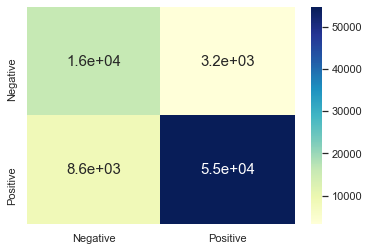

array([[16261,  3230],
       [ 8605, 54660]])

In [54]:
# Random Forest
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
import seaborn as sns

display('Random Forest:')

print('Accuracy:', accuracy_score(y1_test_split, pred_rf))
print('F1 score:', f1_score(y1_test_split, pred_rf, average='weighted'))
print('Precision:', precision_score(y1_test_split, pred_rf, average='weighted'))
print('Recall:', recall_score(y1_test_split, pred_rf, average='weighted'))

cm_rf = confusion_matrix(y1_test_split, pred_rf, labels=[0, 1])

df_cm_rf = pd.DataFrame(cm_rf, columns =['Negative','Positive'])
df_cm_rf.set_index(pd.Index(['Negative','Positive']), 'Sentiment', inplace=True)

sns.set(font_scale=1) 
sns.heatmap(df_cm_rf, annot=True, annot_kws={"size": 15}, cmap="YlGnBu")

plt.show()
display(cm_rf)

'KNN:'

Accuracy: 0.8821958528686742
f1 score: 0.8808795807835235
Precision: 0.8800400823763791
Recall: 0.8821958528686742


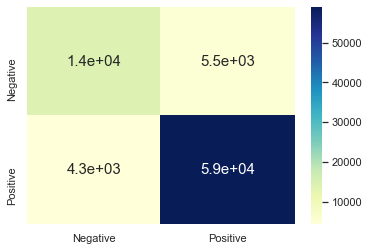

array([[14017,  5474],
       [ 4275, 58990]])

In [55]:
# KNN
display('KNN:')

print('Accuracy:', accuracy_score(y1_test_split, pred_knn))
print('f1 score:', f1_score(y1_test_split, pred_knn, average='weighted'))
print('Precision:', precision_score(y1_test_split, pred_knn, average='weighted'))
print('Recall:', recall_score(y1_test_split, pred_knn, average='weighted'))

cm_knn = confusion_matrix(y1_test_split, pred_knn, labels=[0, 1])

df_cm_knn = pd.DataFrame(cm_knn, columns =['Negative','Positive'])
df_cm_knn.set_index(pd.Index(['Negative','Positive']), 'Sentiment', inplace=True)

sns.set(font_scale=1) 
sns.heatmap(df_cm_knn, annot=True, annot_kws={"size": 15}, cmap="YlGnBu")

plt.show()
display(cm_knn)

'Naive Bayes:'

Accuracy: 0.7679926531006815
f1 score: 0.7101995570813634
Precision: 0.7232570990520117
Recall: 0.7679926531006815

Per class
f1 score: 0.7101995570813634
Precision: 0.7232570990520117
Recall: 0.7679926531006815


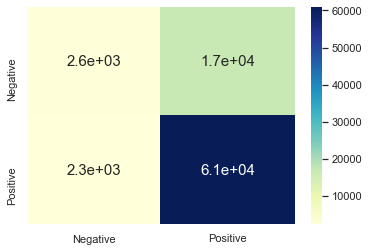

array([[ 2567, 16924],
       [ 2276, 60989]])

In [56]:
# Naive Bayes
display('Naive Bayes:')
print('Accuracy:', accuracy_score(y1_test_split, pred_nb))
print('f1 score:', f1_score(y1_test_split, pred_nb, average='weighted'))
print('Precision:', precision_score(y1_test_split, pred_nb, average='weighted'))
print('Recall:', recall_score(y1_test_split, pred_nb, average='weighted'))
print()
print('Per class')
print('f1 score:', f1_score(y1_test_split, pred_nb, average='weighted'))
print('Precision:', precision_score(y1_test_split, pred_nb, average='weighted'))
print('Recall:', recall_score(y1_test_split, pred_nb, average='weighted'))



cm_nb = confusion_matrix(y1_test_split, pred_nb, labels=[0, 1])

df_cm_nb = pd.DataFrame(cm_nb, columns =['Negative','Positive'])
df_cm_nb.set_index(pd.Index(['Negative','Positive']), 'Sentiment', inplace=True)

sns.set(font_scale=1) 
sns.heatmap(df_cm_nb, annot=True, annot_kws={"size": 15}, cmap="YlGnBu")

plt.show()
display(cm_nb)